# Feedforward Neural Network

In [1]:
import pickle
import time
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
import math

from lstm_data_prep import numpy_prep
from eval_model import accuracy, find_lens, epoch_time
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class FF(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.in_layer = nn.Linear(n_inputs, n_hidden)
    self.out_layer = nn.Linear(n_hidden, n_outputs)

  def forward(self, x):
    y = torch.tanh(self.in_layer(x))
    y = torch.relu(self.out_layer(y))

    return y

In [3]:
class Model:
    def __init__(self, model, loss_fn, optimizer, n_input, n_hidden, n_out, seq_len):
        self.model = model
        self.loss_fn = loss_fn
        self.optim = optimizer
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.seq_len = seq_len
        
        total_params = sum(p.numel() for p in self.model.parameters())
        print(total_params)
    
    def train(self, train_loader, n_epochs):
        train_loss = []
        best_loss = 1e10
        self.model.train()
        for i in range(n_epochs):
            start = time.time()
            avg_loss = 0.
            for X, y in train_loader:
                loss = 0.
                curr_batch_size = X.shape[0]
                X, y = X.to(device), y.to(device)
                self.optim.zero_grad()

                X_lens = find_lens(X)

                output = self.model(X)

                out = output.permute(0, 2, 1)
                target = y.permute(0, 2, 1)

                loss += self.loss_fn(out, target)
                
                loss.backward()
                self.optim.step()
                avg_loss += loss.item()

            end = time.time()

            epoch_mins, epoch_secs = epoch_time(start, end)
            if best_loss > avg_loss:
                best_loss = avg_loss
                torch.save({"ff": self.model.state_dict(), "ff_optimizer": self.optim.state_dict()}, 'ff-model.pt')

        print("Epoch " + str(i + 1) + "/" + str(n_epochs))
        print("Time: " + str(epoch_mins) + " minutes " + str(epoch_secs) + " seconds")
        print("Training loss: " + str(loss.item()))
        print()

        train_loss.append(avg_loss)
            
        return train_loss
    
    def eval(self, x, y):
        check = torch.load("ff-model.pt")
        self.model.load_state_dict(check["ff"])
        self.optim.load_state_dict(check["ff_optimizer"])
        with torch.no_grad():
            correct = np.zeros(self.seq_len)
            total = np.zeros(self.seq_len)
            self.model.eval()
            loss = 0.
            curr_batch_size = x.shape[0]
            X, Y = x.to(device), y.to(device)
            X_lens = find_lens(X)

            out = self.model(X)

            top_value, top_index = out.topk(1)

            final = torch.zeros(y.shape).to(device)
            for clip in range(y.shape[0]):
                for step in range(y.shape[1]):
                    final[clip][step][top_index[clip][step]] = 1
            
            correct, total = accuracy(y.cpu().numpy(), final.cpu().numpy(), correct, total)
            ff_accuracy = correct / total
        
        return ff_accuracy, loss

    def findIndex(self, val, arr):
        index = -1
        for x in range(arr.shape[0]):
            if val == arr[x].item():
                index = x
                break
        return index
    
    def random_samples(self, X, num_seq=90, pad=0.):
        X_random = []
        X_lens = find_lens(X)
        for i in range(X.shape[0]):
            X_batch = np.random.rand(size=(X_lens[i], X.shape[-1]))
            if X_lens[i] < self.seq_len:
                X_pad = np.array([[pad]*X.shape[-1]]*(self.seq_len - X_lens[i]))
                X_batch = np.append(X_batch, X_pad, axis=0)
            X_random.append(X_batch)
            X_random = np.array(X_random)
        return X_random
        
    def rand_test(self, X, y_test, n_samples=20, percentile=90):
        rand_acc_array = []
        for sample in range(n_samples):
            X_random = torch.from_numpy(self.random_samples(X)).float().to(device)
            ff_rand_acc = self.eval(X_random, y_test)
            rand_acc_array.append(ff_rand_acc)
        
        plot = np.percentile(np.sort(np.array(rand_acc_array), axis=0), percentile, axis=0)
        return plot.squeeze(0)

In [4]:
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)

X_train, y_train, X_t, y_t = numpy_prep(TS, pad = 0.)

batch_size = 32

train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

X_test = torch.from_numpy(X_t).float().to(device)
y_test = torch.from_numpy(y_t).float().to(device)

c:\Users\annax\Documents\GitHub\srp-lab-notebook\hcp_data\lstm_data_prep.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_padded = paddingArr(np.array(X_arr), pad=pad)


In [14]:
EPOCHS = 20
n_input = 300
n_hidden = 2431
n_output = 15
seq_len = 90
learning_rate = 2e-3

ff = FF(n_input, n_hidden, n_output).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(ff.parameters(), lr=learning_rate)

model = Model(ff, loss_fn, optimizer, n_input, n_hidden, n_output, seq_len)

768211


In [15]:
train_loss = model.train(train_loader, n_epochs=EPOCHS)

KeyboardInterrupt: 

In [ ]:
ff_acc, test_loss = model.eval(X_test, y_test)
%store ff_acc

Stored 'ff_acc' (ndarray)


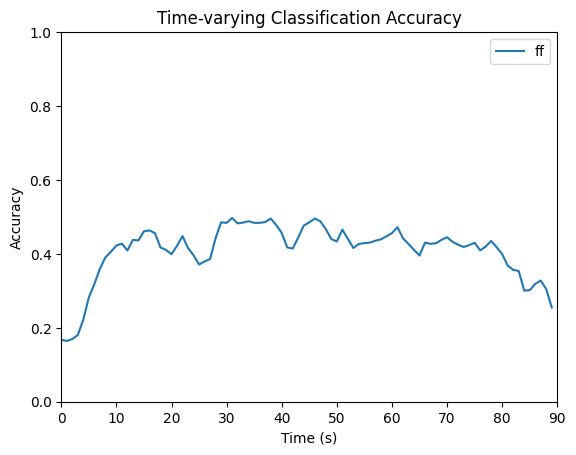

In [ ]:
xAx = [i for i in range(0,90)]
plt.plot(xAx, ff_acc, label="ff")
#plt.plot(xAx, rand_acc, label="random")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xlim(0,90)
plt.title("Time-varying Classification Accuracy")
plt.legend()
plt.show()